<a href="https://colab.research.google.com/github/bjentwistle/PythonFundamentals/blob/main/Projects/Final_Decision_Tree_coded_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Decision Tree Project
---

## Coding a simple decision tree
---

In this worksheet we are going to work with a data set, using the idea of a decision tree class.  We are going to simplify the model and use Python code to make a simple decision tree classification model.  We will do this for two reasons:
*   writing the code is often good for helping to understand what is going on under the bonnet of a library function
*   it is a good coding exercise for practice as it mostly depends on calculations and if..elif..else statements

In this worksheet we are going to code a decision tree which will use the calculated probabilities to make decisions about whether a row of given data would be classified as Iris-virginica, or not, based on sepal and petal dimensions.  It is easier to classify between two values (Iris-virginica or not).  Later, using this information, species would be further predicted by probabilities of error.

![Iris-petals and sepals](https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg)

The workflow is:
*  divide the data set into 70% of the rows for training and 30% for testing  (we can increase the size of the training set later)
*  find the median for each of the 4 size columns
*  calculate the proportion of each column that are on or above median that are of a species (ie proportion of petal-lengths on or above median that are Iris-virginica)
*  infer the proportion of each that are not of that species (using 1 - proportion above).  In both cases we are looking to find if either of these is 1, which could be infered as definitely not that species. 
*  calculate a Gini Index that will indicate the probability that a prediction will be incorrect
*  use the results of the Gini Index to model a decision tree
*  code the decision tree model into a function that will return whether or not a row in the test set is predicted to be of species Iris-virginica
*  use the decision tree function to predict, for each row in the test set, if the species will be Iris-virginicia or not, using a set of nested if statements to classify
*  compare the predicted values against the actual values in the test set - what proportion were predicted correctly?


### Exercise 1 - investigate the iris data set
---
Let's start by looking at the data.  We are going to use a data set that contains data on iris flowers.

Read the data at this location: https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv into a dataframe called iris_data

The columns in the CSV file do not have headings, when you read the file, add column headings like this:
```
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']
iris_data = pd.read_csv(url, name=names)
```
*  Take a look at the column info (how many columns, what type of data, any missing data?)
*  Take a look at the data values in the first 10 and the last 10 records to get an idea of the type of values included
*  Find out how many unique values there are in the species column
*  Find out the maximum, minimum, median and upper and lower quartile values in each of the columns


In [ ]:
import pandas as pd
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species'] #adds column names to the csv df
iris_data = pd.read_csv(url, names=names)
print(iris_data.species.unique()) # displays how many unique iris' are in the species column
iris_data.info() # no values are missing - all 150 rows have data in them

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal-length  150 non-null    float64
 1   sepal-width   150 non-null    float64
 2   petal-length  150 non-null    float64
 3   petal-width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


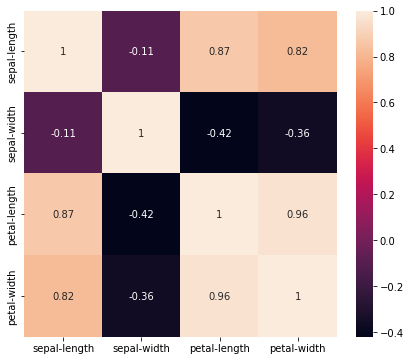

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

corr = iris_data.corr()
corr
fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(corr, annot=True, ax = ax)
plt.show()

This heat map shows there is a postive correlation between **sepal length** and **petal length** (0.87) and a stronger correlation between **petal length** and **petal width**(0.96). There is also a correlation between **sepal length** and petal length (0.82)

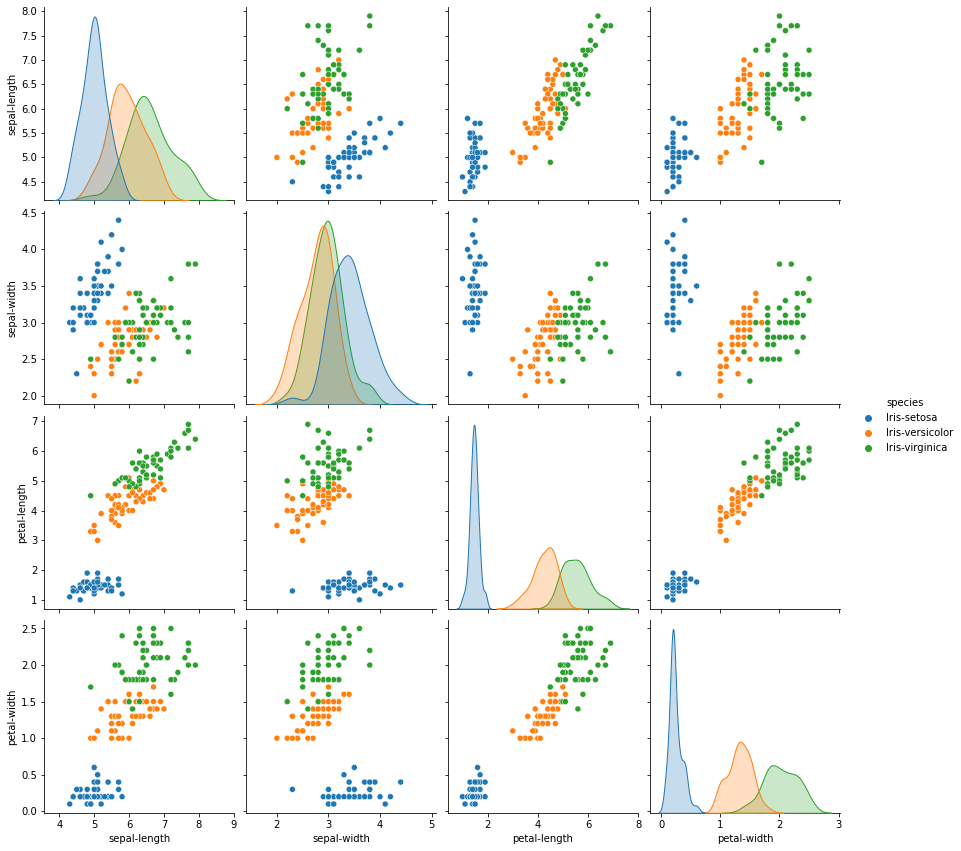

In [ ]:
#Code from Chengjing called pairplot of our iris data.
sns.pairplot(iris_data, hue='species', height = 3, diag_kind = "kde")
plt.show()

### Exercise 2 - split the data into train and test sets
---

Split the data set into and 70% train, 30% test, split.  From now, just use the train data set.


In [ ]:
# import the train_test_split function
from sklearn.model_selection import train_test_split

# create the classification variables from the all columns (creates two dfs randomly selecting rows for train = 120 rows and test = 30 rows 
# using the train_test_spilt function in sklearn library)
train, test = train_test_split(iris_data, test_size=0.30)
train # dataset for training our model

,sepal-length,sepal-width,petal-length,petal-width,species
28,5.2,3.4,1.4,0.2,Iris-setosa
57,4.9,2.4,3.3,1.0,Iris-versicolor
60,5.0,2.0,3.5,1.0,Iris-versicolor
76,6.8,2.8,4.8,1.4,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica
...,...,...,...,...,...
117,7.7,3.8,6.7,2.2,Iris-virginica
24,4.8,3.4,1.9,0.2,Iris-setosa
68,6.2,2.2,4.5,1.5,Iris-versicolor
62,6.0,2.2,4.0,1.0,Iris-versicolor


### Exercise 3 - assumptions and classification
---

Let's make some assumptions based on the data

1.  Iris-setosa, Iris-versicolor, Iris-virginica are the full range of types of iris to be analysed
2.  Although this is a small data set, the means are fairly representative

With these in mind, let's start by classifying sepal/petal size into long/short and wide/narrow with values on or above the mean taken as long or wide and those below as short or narrow.

This is a starting point.  We will be trying to find a value (indicator) for each column where rows on or above do not contain any of a particular species, this might indicate that this column is a good (if not rough) indicator of species.

*  Drop any null values from each column

Calculate, and store the means of the four columns

*  **Test**:
Display train.describe() to see the value of the means of the training set. Print the four means and compare to the output of train.describe() to check that they have been calculated correctly.

*  Create a new dataframe with the numeric columns encoded so show a 1 for any value that is above the mean for its column and 0 for any that isn't.




In [ ]:
#Calculate the mean values for each column.
mean_sl = train["sepal-length"].mean()
print("mean_sepal_length = ", mean_sl)

mean_sw = train["sepal-width"].mean()
print("mean_sepal_width = ", mean_sw)

mean_pl = train["petal-length"].mean()
print("mean_petal_length = ", mean_pl)

mean_pw = train["petal-width"].mean()
print("mean_petal_width = ", mean_pw)

mean_sepal_length =  5.894285714285714
mean_sepal_width =  3.0399999999999987
mean_petal_length =  3.870476190476188
mean_petal_width =  1.2380952380952384


In [ ]:
train.describe() # to check my calculations are correct above.

,sepal-length,sepal-width,petal-length,petal-width
count,105.000000,105.000000,105.000000,105.000000
mean,5.894286,3.040000,3.870476,1.238095
std,0.884680,0.447772,1.802131,0.757955
min,4.300000,2.000000,1.100000,0.100000
25%,5.100000,2.800000,1.600000,0.400000
50%,5.800000,3.000000,4.500000,1.400000
75%,6.500000,3.300000,5.200000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
# get the mean for each column and apply a function to encode into 1 (on or above mean) and 0 (below mean)
train_encoded = train #make a copy of train

def encode(df, **kdws):
  key = kdws['key']
  indicator = kdws['indicator']
  if df[key] >= indicator:
    return 1
  else:
    return 0
# run the function for each column so that each of the four columns are encoded, then drop the original columns, saving as a new dataframe
train_encoded['sepal-length_long'] = train_encoded.apply(encode, axis=1, key='sepal-length', indicator=mean_sl)
train_encoded['sepal-width_wide'] = train_encoded.apply(encode, axis=1, key='sepal-width', indicator=mean_sw)
train_encoded['petal-length_long'] = train_encoded.apply(encode, axis=1, key='petal-length', indicator=mean_pl)
train_encoded['petal-width_wide'] = train_encoded.apply(encode, axis=1, key='petal-width', indicator=mean_pw)
train_encoded

,sepal-length,sepal-width,petal-length,petal-width,species,sepal-length_long,sepal-width_wide,petal-length_long,petal-width_wide
28,5.2,3.4,1.4,0.2,Iris-setosa,0,1,0,0
57,4.9,2.4,3.3,1.0,Iris-versicolor,0,0,0,0
60,5.0,2.0,3.5,1.0,Iris-versicolor,0,0,0,0
76,6.8,2.8,4.8,1.4,Iris-versicolor,1,0,1,1
100,6.3,3.3,6.0,2.5,Iris-virginica,1,1,1,1
...,...,...,...,...,...,...,...,...,...
117,7.7,3.8,6.7,2.2,Iris-virginica,1,1,1,1
24,4.8,3.4,1.9,0.2,Iris-setosa,0,1,0,0
68,6.2,2.2,4.5,1.5,Iris-versicolor,1,0,1,1
62,6.0,2.2,4.0,1.0,Iris-versicolor,1,0,1,0


### Exercise 4 - Calculate the proportion of values on or above the mean that are of each species

We are going to focus on the `Iris-virginica` species first.

First we will calculate, for each dimension column (`sepal-length, sepal-width, petal-length, petal-width`) what proportion of values in that column, where the value is on or above the mean, are classified as `Iris-virginica`.

We will do this by filtering all the records in each column of the the `train` set that are on or above the mean and match the species .  Then use the outcome to calculate the proportion of the full `train` set for which a value on or above the mean that are of species `Iris-virginica`.

*  filter for values in the `sepal-length` column being on or above the mean and the species column being `Iris-virginica`.  Then divide the count of rows in this filtered dataset by the count of rows in a second data set, filtered for just the value being on or above the mean.

*  Do this for all four columns, for `Iris-virginica`  (4 operations).

Print the results to see which columns look like they might most reliably predict the species as `Iris-virginica` (the result is as close as possible to 1).  The highest numbers may indicate the most reliable indicators, but we will do some more before coming to this conclusion.

*  By definition, those on or above the mean that are NOT Iris_virginica will be `1 - the proportion of those that are.  Calculate these

The first one has been done for you.

*  We will also need the proportion of those BELOW the median that are NOT Iris-virginica.  Calculate these in the same way



In [ ]:
train_encoded.dtypes

sepal-length         float64
sepal-width          float64
petal-length         float64
petal-width          float64
species               object
sepal-length_long      int64
sepal-width_wide       int64
petal-length_long      int64
petal-width_wide       int64
dtype: object

### Exercise 5 - Calculate the proportion of each column where the value is above and then below mean that are of species `Iris-virginica`



In [ ]:
train_count = train_encoded["species"].count()
print("Train count = ", train_count)

# calculate the proportion of results where the value is on or above mean that are of the species Iris-virginica
def calc_proportions(df,column, species, check):
  proportion = df.loc[(df["species"] == species) & (df[column]== check)]
  proportion_count = proportion["species"].count()
  #print("Iris-virginica count = ", proportion_count)

  percentage = (proportion_count/train_count)
  #print(column, " in train_count = ", percentage,"%")

  dict_out = {column: percentage}
  return dict_out

#call function 4 different times for each column in Iris DF
iris_virginica_dict1 = calc_proportions(train_encoded,"sepal-length_long","Iris-virginica",1)
iris_virginica_dict2 = calc_proportions(train_encoded,"sepal-width_wide","Iris-virginica",1)
iris_virginica_dict3 = calc_proportions(train_encoded,"petal-length_long","Iris-virginica",1)
iris_virginica_dict4 = calc_proportions(train_encoded,"petal-width_wide","Iris-virginica",1)
print(iris_virginica_dict1)
print(iris_virginica_dict2)
print(iris_virginica_dict3)
print(iris_virginica_dict4)

Train count =  105
{'sepal-length_long': 0.3238095238095238}
{'sepal-width_wide': 0.12380952380952381}
{'petal-length_long': 0.37142857142857144}
{'petal-width_wide': 0.37142857142857144}


Here none of the species are excluded so this indicates we can't use this to initially identify any species.

# Repeat the code above, this time looking for values below the mean

### **This is for the proportion of values under the mean (ie encoded 0) for Iris Virginica**

In [ ]:
# calculate the proportion of results where the value is below median that are of the species Iris-virginica
train_count = train_encoded["species"].count()
#print("Train count = ", train_count)

#call function 4 different times for each column in Iris DF using function in above cell
iris_virginica_dict5 = calc_proportions(train_encoded,"sepal-length_long","Iris-virginica",0)
iris_virginica_dict6 = calc_proportions(train_encoded,"sepal-width_wide","Iris-virginica",0)
iris_virginica_dict7 = calc_proportions(train_encoded,"petal-length_long","Iris-virginica",0)
iris_virginica_dict8 = calc_proportions(train_encoded,"petal-width_wide","Iris-virginica",0)
print(iris_virginica_dict5)
print(iris_virginica_dict6)
print(iris_virginica_dict7)
print(iris_virginica_dict8)

{'sepal-length_long': 0.047619047619047616}
{'sepal-width_wide': 0.24761904761904763}
{'petal-length_long': 0.0}
{'petal-width_wide': 0.0}


There are two instances where Iris Virginica is absent from the data, ie below the mean for: {'petal-length_long': 0.0}
{'petal-width_wide': 0.0}

### Exercise 5 - calculate for the other two Iris species
---

Do the same calculations as above for the Iris-setosa species, then for the Iris-versicolor species.






## Iris-setosa species

In [ ]:
#call function 4 different times for each column in Iris DF
iris_setosa_dict1 = calc_proportions(train_encoded,"sepal-length_long","Iris-setosa",1)
iris_setosa_dict2 = calc_proportions(train_encoded,"sepal-width_wide","Iris-setosa",1)
iris_setosa_dict3 = calc_proportions(train_encoded,"petal-length_long","Iris-setosa",1)
iris_setosa_dict4 = calc_proportions(train_encoded,"petal-width_wide","Iris-setosa",1)
print("Proportions of Iris Setosa on or above mean")
print(iris_setosa_dict1)
print(iris_setosa_dict2)
print(iris_setosa_dict3)
print(iris_setosa_dict4)

#call function 4 different times for each column in Iris DF using function in above cell
iris_setosa_dict5 = calc_proportions(train_encoded,"sepal-length_long","Iris-setosa",0)
iris_setosa_dict6 = calc_proportions(train_encoded,"sepal-width_wide","Iris-setosa",0)
iris_setosa_dict7 = calc_proportions(train_encoded,"petal-length_long","Iris-setosa",0)
iris_setosa_dict8 = calc_proportions(train_encoded,"petal-width_wide","Iris-setosa",0)
print("Proportions of Iris Setosa belove mean")
print(iris_setosa_dict5)
print(iris_setosa_dict6)
print(iris_setosa_dict7)
print(iris_setosa_dict8)

Proportions of Iris Setosa on or above mean
{'sepal-length_long': 0.0}
{'sepal-width_wide': 0.2571428571428571}
{'petal-length_long': 0.0}
{'petal-width_wide': 0.0}
Proportions of Iris Setosa belove mean
{'sepal-length_long': 0.3142857142857143}
{'sepal-width_wide': 0.05714285714285714}
{'petal-length_long': 0.3142857142857143}
{'petal-width_wide': 0.3142857142857143}


Here we have 3 measurements for Iris Setosa that are excluded in the selection - 
Proportions of Iris Setosa on or above mean

{'sepal-length_long': 0.0}
{'petal-length_long': 0.0}
{'petal-width_wide': 0.0}

## Iris-versicolor

In [ ]:
#call function 4 different times for each column in Iris DF
iris_versicolor_dict1 = calc_proportions(train_encoded,"sepal-length_long","Iris-versicolor",1)
iris_versicolor_dict2 = calc_proportions(train_encoded,"sepal-width_wide","Iris-versicolor",1)
iris_versicolor_dict3 = calc_proportions(train_encoded,"petal-length_long","Iris-versicolor",1)
iris_versicolor_dict4 = calc_proportions(train_encoded,"petal-width_wide","Iris-versicolor",1)
print("Proportions of Iris Versicolor on or above the mean")
print(iris_versicolor_dict1)
print(iris_versicolor_dict2)
print(iris_versicolor_dict3)
print(iris_versicolor_dict4)

#call function 4 different times for each column in Iris DF using function in above cell
iris_versicolor_dict5 = calc_proportions(train_encoded,"sepal-length_long","Iris-versicolor",0)
iris_versicolor_dict6 = calc_proportions(train_encoded,"sepal-width_wide","Iris-versicolor",0)
iris_versicolor_dict7 = calc_proportions(train_encoded,"petal-length_long","Iris-versicolor",0)
iris_versicolor_dict8 = calc_proportions(train_encoded,"petal-width_wide","Iris-versicolor",0)
print("Proportions of Iris Versicolor below the mean")
print(iris_versicolor_dict5)
print(iris_versicolor_dict6)
print(iris_versicolor_dict7)
print(iris_versicolor_dict8)

Proportions of Iris Versicolor on or above the mean
{'sepal-length_long': 0.17142857142857143}
{'sepal-width_wide': 0.05714285714285714}
{'petal-length_long': 0.2571428571428571}
{'petal-width_wide': 0.20952380952380953}
Proportions of Iris Versicolor below the mean
{'sepal-length_long': 0.14285714285714285}
{'sepal-width_wide': 0.2571428571428571}
{'petal-length_long': 0.05714285714285714}
{'petal-width_wide': 0.10476190476190476}


There are no obvious indicators here either way.

### Exercise 6 - predict from the results
---

Create a list of dictionaries from the results Exercise 4 and 5 (e.g. {'species':..., 'above_mean': 0.xx, 'below_mean': 0.xx}  

Then use a loop to go through the list and print:  
*  any species and indicator (above or below mean) that can reliably be predicted.  A reliable prediction may be one over 0.5

In [ ]:
# show which columns are reliable predictors



### Exercise 6 - Make a decision tree
---

Use pencil and paper or a graphical application to create a decision tree for Iris-virginica, using the following rules (use the picture below as a guide):

*  The column with the highest indicator is placed at the top
*  Other columns are placed in order below
*  The rest of the columns are placed in order below these

Any column where one branch (on or above mean OR below mean) has an indicator of 0, could be classified as a strong indicator of Iris_virginica being the species.  Anything else, unless there is something very close to 0, could be classified as a weak indicator of Iris_virginica being the species.

Let's code the decision tree using the following logic for this decision tree (yours might be slightly different):

![Decision tree](https://drive.google.com/uc?id=1CTo23EHwR2IPCRjcfSyCQsT_oQ5Exwso)

In the decision tree above, there is no certainty below petal-length so our decision tree will only include petal-width and petal-length.




In [ ]:
def get_species(df):
  # ADD CODE HERE TO RETURN None if petal-width is below mean (encoded as 0) or if petal-length is below mean (encoded as 0), otherwise return 'Iris-virginia'
    if df['petal-width'] == 0:
        return None
        if df['petal-length'] == 0:
            return None
            if df['sepal-length'] == 0:
                return None
    return 'Iris-virginica' 

# use the get_species(df) function to predict the species, count how many are predicted correct and use this to calculate the proportion correct
correct = 0
test_size = test.shape[0]
for i in range(0, test_size):
  species = get_species(test.iloc[i])
  if species == test.iloc[i]['species']:
      correct += 1

print ("Proportion correctly identified", correct / test_size) 


Proportion correctly identified 0.24444444444444444


### Exercise 7 - change the measure

We are currently using the mean to act as the decision making line.  We can use the decision tree with a different line.

Change the mean values so that you are instead using the median instead for all four columns.  The code should not need changing except for where you calculated the mean.

Run all the code again.  Is the proportion of correct values better this time?   Is the decision tree still appropriate?


What do you notice? (write your answer here)

### Exercise 8 - try different measures
---

Do the same again but with upper quantile, then again with the lower quantile.  Is it making any difference?  Which give the best looking results?

### Exercise 9 - try a different species

Run the mean test again for the Iris-versicolor species.  Again, try some different decision making lines.

What are the results.  Record them in the text cell below:

Write your answers here:  

# New logic introduced in this worksheet:

1.  Adding headings to a CSV if none currently exist
2.  Splitting a data set into train and test sets

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


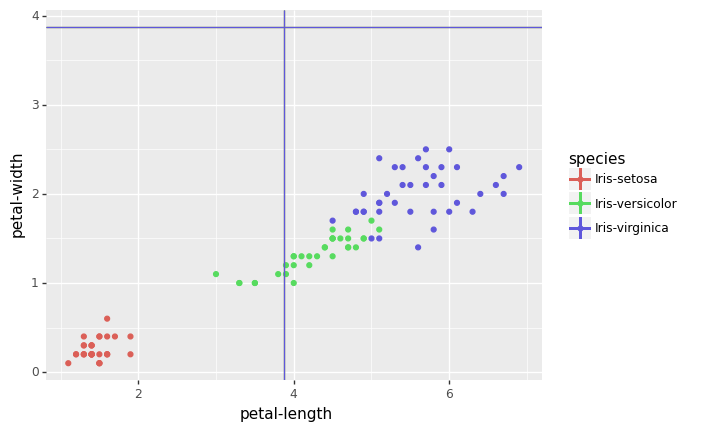

<ggplot: (8756479493221)>

In [ ]:
## this type of plot will show the distribution on a chart
from plotnine import *
ggplot(train, aes(x='petal-length', y='petal-width', color='species')) + geom_point() + geom_vline(train, aes(xintercept=train['petal-length'].mean(), color='species')) + geom_hline(train, aes(yintercept=train['petal-length'].mean(), color='species'))